# 0.Dependencies

In [1]:
# Download the dataset in YOLOv8 format. (I used Roboflow)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
import numpy as np
import torchvision
from torchvision.transforms import v2
import os
import cv2
import albumentations as A
from PIL import Image
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [8]:
# Dataset Parameters
BATCH_SIZE = 32
NUM_BOXES = 2
GRID_SIZE = 7
IMAGE_SIZE = 224
CLASSES = ['bus', 'car', 'heavy-truck', 'motorcycle']
NUM_CLASSES = len(CLASSES)

NUM_WORKERS = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Parameters
epochs = 100
initial_lr = 0.001
box_loss = 5.0
noobj_loss = 0.5
obj_loss = 2.0
cls_loss = 1.0

# Test Parameters
objectness_threshold = 0.3
nms_threshold = 0.45

# 1.Dataset

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, num_classes, image_size, grid_size, transform=None, augment=True):

        self.nc = num_classes
        self.img_size = image_size
        self.grid = grid_size

        self.cutout = self.CutOut()
        self.transform = transform
        self.toTensor = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

        self.images = []
        self.labels = []
        self.augment = augment
        if augment:
            self.augmentor = self.get_augmentor()

        self.read_data(path)

    def CutOut(self):
        custom_transforms = []

        for i in range(8):
            custom_transforms.append(torchvision.transforms.RandomErasing(p=1.0, scale=(0.02, 0.04), ratio=(0.3, 1), value=1))

        return torchvision.transforms.Compose(custom_transforms)

    def get_augmentor(self):
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.Rotate(15, p=0.5),
            A.GaussNoise(var_limit=(20.0, 100.0), p=0.5),  # Add Gaussian noise
            A.GaussianBlur(blur_limit=(3, self.grid), p=0.5),  # Apply Gaussian blur
            A.RandomCrop(450, 450, p=0.5),
            A.Resize(self.img_size, self.img_size, p=1)
        ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        label = [list(map(float, box)) for box in label]

        if self.augment:
            bboxes =  [box[1:] for box in label]
            classes = [box[0] for box in label]
            augmented = self.augmentor(image=image, bboxes=bboxes, labels=classes)
            image = augmented['image']

            label = [[c, *box] for c, box in zip(augmented['labels'], augmented['bboxes'])]


            image = self.toTensor(image)
            if random.random() < 0.3:
                image = self.cutout(image)
        else:
            image = self.transform(image)

        return image, self.convert_label_matrix(label)

    def read_data(self, path):
        image_paths = os.path.join(path, 'images')
        label_paths = os.path.join(path, 'labels')
        files = os.listdir(image_paths)
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(path, 'images', file)
                label_path = image_path.replace('.jpg', '.txt').replace("images", "labels")

                with open(label_path, 'r') as f:
                    annotations = f.readlines()
                    annotations = [label.strip().split(' ') for label in annotations]

                    self.labels.append(annotations)

                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                self.images.append(img)


    def convert_label_matrix(self, labels):
        size = len(labels)
        label_matrix = torch.zeros((self.grid, self.grid, 5 + self.nc))

        for k in range(size):
            class_label = int(labels[k][0])
            x = float(labels[k][1])
            y = float(labels[k][2])
            width = float(labels[k][3])
            height = float(labels[k][4])

            if x==1:
                x = 0.9999
            if y==1:
                y = 0.9999

            i = int(self.grid * y)
            j = int(self.grid * x)
            x_cell = self.grid * x - j
            y_cell = self.grid * y - i

            if label_matrix[i][j][self.nc] == 0:
                label_matrix[i][j][self.nc] = 1

                box_coordinates = torch.tensor([x_cell, y_cell, width, height])
                label_matrix[i][j][self.nc+1:self.nc+5] = box_coordinates

                label_matrix[i][j][class_label] = 1

        return label_matrix

In [ ]:
def get_transform(img_size):
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    custom_transforms.append(torchvision.transforms.Resize((img_size, img_size), antialias=True))

    return torchvision.transforms.Compose(custom_transforms)

valid_ds = Dataset('./valid', NUM_CLASSES, IMAGE_SIZE, GRID_SIZE, get_transform(IMAGE_SIZE), False)
train_ds = Dataset('./train', NUM_CLASSES, IMAGE_SIZE, GRID_SIZE, None, True)

valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers= NUM_WORKERS)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers= NUM_WORKERS)

## Testing the Dataset

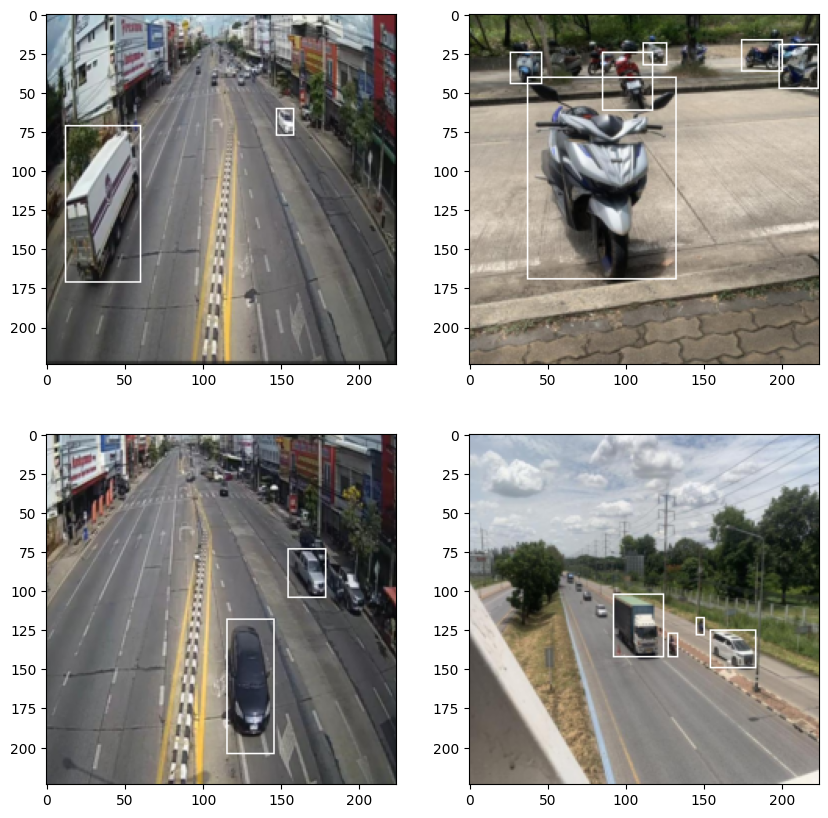

In [ ]:
def get_boxes(matrix, grid, img_size, nc):
    labels = []
    for i in range(grid):
        for j in range(grid):
            if matrix[i][j][nc] == 1:
                c = torch.argmax(matrix[i][j][:nc])
                x = (j+matrix[i][j][nc+1]) * (img_size / grid)
                y = (i+matrix[i][j][nc+2]) * (img_size / grid)
                w = matrix[i][j][nc+3] * img_size
                h = matrix[i][j][nc+4] * img_size
                labels.append([int(c), int(x), int(y), int(w), int(h)])
    return torch.Tensor(labels)

images, labels = next(iter(valid_loader))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        img = images[i*2+j].permute(1, 2, 0).mul(255).byte().numpy()
        boxes = get_boxes(labels[i*2+j], GRID_SIZE, IMAGE_SIZE, NUM_CLASSES)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        for box in boxes:
            xmin = int(box[1] - box[3]/2)
            ymin = int(box[2] - box[4]/2)
            xmax = int(box[1] + box[3]/2)
            ymax = int(box[2] + box[4]/2)

            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 1)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
plt.show()


# 2.Model

In [11]:
class Head(nn.Module):
    def __init__(self, num_boxes, num_classes, grid_size):
        super(Head, self).__init__()

        self.detect1 = nn.Conv2d(1280, 1280, 3, stride=1, padding=1, bias=False, groups=1280)
        self.bn1 = nn.BatchNorm2d(1280)
        self.act1 = nn.LeakyReLU(0.1, inplace=True)

        self.detect2 = nn.Conv2d(1280, 1280, 1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.act2 = nn.LeakyReLU(0.1, inplace=True)

        self.detect3 = nn.Conv2d(1280, 1024, 1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)
        self.act3 = nn.LeakyReLU(0.1, inplace=True)

        self.detect4 = nn.Conv2d(1024, num_boxes * 5 + num_classes, 1, stride=1, padding=0)

    def forward(self, x):
        x = self.detect1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.detect2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.detect3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.detect4(x)
        return x.permute(0, 2, 3, 1)


class YOLO(nn.Module):
    def __init__(self, num_boxes, num_classes, grid_size):
        super(YOLO, self).__init__()

        self.backbone = self.get_backbone()
        self.head = Head(num_boxes, num_classes, grid_size)


    def get_backbone(self):
        backbone = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1').features

        for param in backbone.parameters():
            param.requires_grad = True
        return backbone


    def forward(self, x):
        x = self.backbone(x)
        return self.head(x)

# 3.Loss Function

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='sum'):
        super(FocalLoss, self).__init__()

        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs.sigmoid(), min=1e-7, max=1-1e-7)
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class YOLOLoss(nn.Module):
    def __init__(self, num_boxes, num_classes, grid_size, coord, noobj, obj, cls):
        super(YOLOLoss, self).__init__()
        self.grid = grid_size
        self.num_boxes = num_boxes
        self.nc = num_classes
        self.LAMBDA_COORD = coord
        self.LAMBDA_NOOBJ = noobj
        self.LAMBDA_OBJ = obj
        self.LAMBDA_CLS = cls

        self.grid_x = torch.arange(7).view(1, 7, 1, 1).to(device)
        self.grid_y = torch.arange(7).view(1, 1, 7, 1).to(device)

        self.focal = FocalLoss()

    def forward(self, predictions, target):
        pred1_box = torch.cat([(predictions[..., self.nc+1:self.nc+2]+self.grid_x)/self.grid, (predictions[..., self.nc+2:self.nc+3]+self.grid_y)/self.grid, predictions[..., self.nc+3:self.nc+5]], dim=-1)
        pred2_box = torch.cat([(predictions[..., self.nc+6:self.nc+7]+self.grid_x)/self.grid, (predictions[..., self.nc+7:self.nc+8]+self.grid_y)/self.grid, predictions[..., self.nc+8:self.nc+10]], dim=-1)
        target_box = torch.cat([(target[..., self.nc+1:self.nc+2]+self.grid_x)/self.grid, (target[..., self.nc+2:self.nc+3]+self.grid_y)/self.grid, target[..., self.nc+3:self.nc+5]], dim=-1)

        iou_b1 = self.intersection_over_union(pred1_box, target_box)
        iou_b2 = self.intersection_over_union(pred2_box, target_box)
        ious = torch.stack([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)
        bestbox = bestbox.squeeze(0)
        exists_box = target[..., self.nc:self.nc+1]

        # OBJECT LOSS
        pred_box = (bestbox * predictions[..., self.nc+5:self.nc+6] + (1 - bestbox) * predictions[..., self.nc:self.nc+1])
        object_loss = self.focal(pred_box[exists_box==1], exists_box[exists_box==1])

        # NO OBJECT LOSS
        no_object_loss = self.focal(predictions[..., self.nc:self.nc+1][exists_box==0], exists_box[exists_box==0])
        no_object_loss += self.focal(predictions[..., self.nc+5:self.nc+6][exists_box==0], exists_box[exists_box==0])

        # CLASS LOSS
        class_loss = self.focal(predictions[..., :self.nc][exists_box.squeeze(-1)==1], target[..., :self.nc][exists_box.squeeze(-1)==1])

        # BOX LOSS
        box_predictions = (bestbox * pred2_box + (1 - bestbox) * pred1_box)
        box_loss = self.DIoU(box_predictions, target_box, exists_box)

        total_loss = self.LAMBDA_COORD * box_loss + self.LAMBDA_NOOBJ * no_object_loss + self.LAMBDA_OBJ * object_loss + self.LAMBDA_CLS * class_loss
        return total_loss


    def DIoU(self, preds, targets, exists):
        pred_rect_x_min = preds[..., 0:1] - preds[..., 2:3] / 2
        pred_rect_y_min = preds[..., 1:2] - preds[..., 3:4] / 2
        pred_rect_x_max = preds[..., 0:1] + preds[..., 2:3] / 2
        pred_rect_y_max = preds[..., 1:2] + preds[..., 3:4] / 2
        true_rect_x_min = targets[..., 0:1] - targets[..., 2:3] / 2
        true_rect_y_min = targets[..., 1:2] - targets[..., 3:4] / 2
        true_rect_x_max = targets[..., 0:1] + targets[..., 2:3] / 2
        true_rect_y_max = targets[..., 1:2] + targets[..., 3:4] / 2

        x1 = torch.max(pred_rect_x_min, true_rect_x_min)
        y1 = torch.max(pred_rect_y_min, true_rect_y_min)
        x2 = torch.min(pred_rect_x_max, true_rect_x_max)
        y2 = torch.min(pred_rect_y_max, true_rect_y_max)

        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
        box1_area = (pred_rect_x_max - pred_rect_x_min) * (pred_rect_y_max - pred_rect_y_min)
        box2_area = (true_rect_x_max - true_rect_x_min) * (true_rect_y_max - true_rect_y_min)

        combined = box1_area + box2_area - intersection + 1e-7
        iou = intersection / combined

        wrap_w = (torch.max(pred_rect_x_max, true_rect_x_max) - torch.min(pred_rect_x_min, true_rect_x_min))
        wrap_h = (torch.max(pred_rect_y_max, true_rect_y_max) - torch.min(pred_rect_y_min, true_rect_y_min))

        diagonal_dist = torch.pow(wrap_w, 2) + torch.pow(wrap_h, 2) + 1e-7

        centers_dist = (torch.pow(pred_rect_x_max + pred_rect_x_min - true_rect_x_max - true_rect_x_min, 2) + torch.pow(pred_rect_y_max + pred_rect_y_min - true_rect_y_max - true_rect_y_min, 2))
        penalty = centers_dist / diagonal_dist

        diou_loss = (1 - iou + penalty) * exists

        return torch.sum(diou_loss)

    def intersection_over_union(self, boxes_preds, boxes_labels):
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

        x1 = torch.max(box1_x1, box2_x1)
        y1 = torch.max(box1_y1, box2_y1)
        x2 = torch.min(box1_x2, box2_x2)
        y2 = torch.min(box1_y2, box2_y2)

        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
        box1_area = torch.abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
        box2_area = torch.abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

        return intersection / (box1_area + box2_area - intersection + 1e-7)

# 4.Training

In [ ]:
def train_fn(loader, model, optimizer, scheduler, loss_fn):
    model.train()
    loop = tqdm(loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = loss_fn(out, y)

        mean_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"\t{sum(mean_loss)/len(mean_loss)}")

def valid_fn(loader, model, loss_fn):
    model.eval()
    mean_loss = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)
            mean_loss.append(loss.item())

    print(f"\t{sum(mean_loss)/len(mean_loss)}")

In [ ]:
# Model
model = YOLO(num_boxes=2, num_classes=4, grid_size=7)
model.to(device)

# Loss Function
loss_fn = YOLOLoss(NUM_BOXES, NUM_CLASSES, GRID_SIZE, box_loss, noobj_loss, obj_loss, cls_loss)

total_steps = len(train_loader) * epochs

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=0.0005)

# Scheduler
scheduler = OneCycleLR(optimizer, max_lr=initial_lr, total_steps=total_steps, pct_start=0.2,
                       anneal_strategy='linear', cycle_momentum=False, div_factor=25.0, final_div_factor=1000.0)


for epoch in range(1, epochs+1):
    print(f"Epoch {epoch}")
    print("Train loss: ")
    train_fn(train_loader, model, optimizer, scheduler, loss_fn)

    print("Valid loss: ")
    valid_fn(valid_loader, model, loss_fn)

    lr = optimizer.param_groups[0]['lr']
    print("lr:", lr)
    print()

    # Saving the checkpoints
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pth")
        torch.save(optimizer.state_dict(), f"optimizer_{epoch}.pth")
        torch.save(scheduler.state_dict(), f"scheduler_{epoch}.pth")

# 5.Testing

In [6]:
def get_boxes(matrix, img_size, grid, num_classes, objectness_threshold, nms_threshold):
    bboxes, confidences, classes, labels = [], [], [], []
    for i in range(grid):
        for j in range(grid):
            if matrix[i][j][num_classes] > matrix[i][j][num_classes+5]:
                if F.sigmoid(matrix[i][j][num_classes]) >= objectness_threshold:
                    c = torch.argmax(matrix[i][j][:num_classes])
                    x = (j+matrix[i][j][num_classes+1]) * (img_size / grid)
                    y = (i+matrix[i][j][num_classes++2]) * (img_size / grid)
                    w = matrix[i][j][num_classes+3] * img_size
                    h = matrix[i][j][num_classes+4] * img_size
                    box = [float((x-w/2).clamp(0, img_size)), float((y-h/2).clamp(0, img_size)), float((x+w/2).clamp(0, img_size)), float((y+h/2).clamp(0, img_size))]
                    bboxes.append(box)
                    confidences.append(float(matrix[i][j][num_classes]))
                    classes.append(c)
                    labels.append([int(c), x, y, w, h])
            else:
                if F.sigmoid(matrix[i][j][num_classes+5]) >= objectness_threshold:
                    c = torch.argmax(matrix[i][j][:num_classes])
                    x = (j+matrix[i][j][num_classes+6]) * (img_size / grid)
                    y = (i+matrix[i][j][num_classes+7]) * (img_size / grid)
                    w = matrix[i][j][num_classes+8] * img_size
                    h = matrix[i][j][num_classes+9] * img_size
                    box = [float((x-w/2).clamp(0, img_size)), float((y-h/2).clamp(0, img_size)), float((x+w/2).clamp(0, img_size)), float((y+h/2).clamp(0, img_size))]
                    bboxes.append(box)
                    confidences.append(float(matrix[i][j][num_classes+5]))
                    classes.append(float(c))
                    labels.append([int(c), x, y, w, h])
    if len(bboxes) == 0:
        return []

    bboxes = torch.Tensor(bboxes)
    confidences = torch.Tensor(confidences)
    classes = torch.Tensor(classes)

    indices = torchvision.ops.batched_nms(bboxes, confidences, classes, nms_threshold)
    return torch.Tensor([labels[i] for i in indices])

In [7]:
test_ds = Dataset('./test', NUM_CLASSES, IMAGE_SIZE, GRID_SIZE, get_transform(IMAGE_SIZE), False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True)

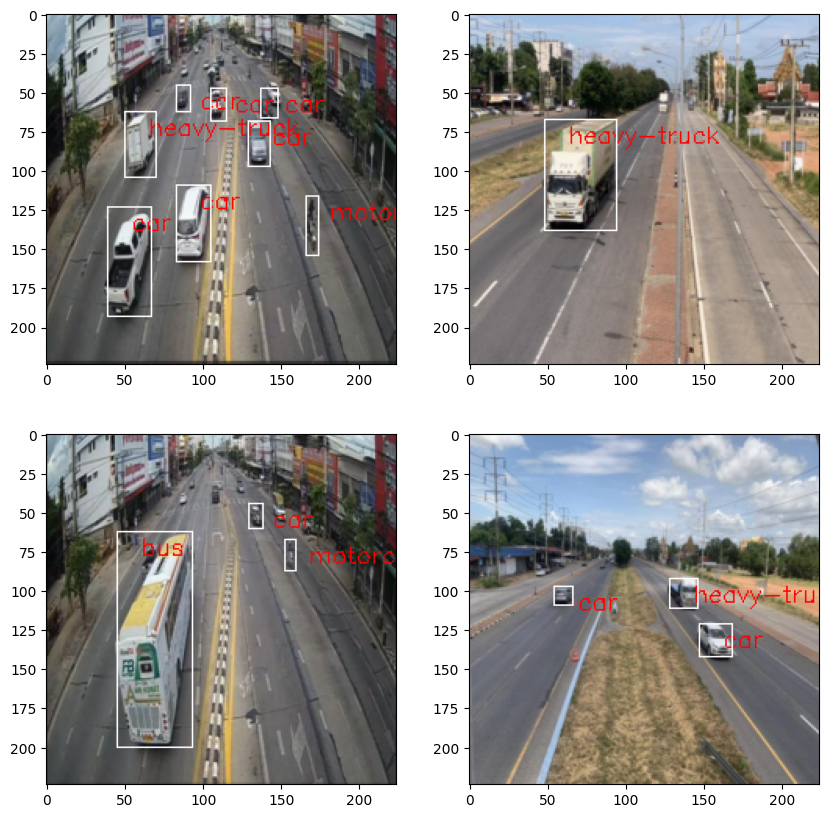

In [16]:
images, labels = next(iter(test_loader))
images = images.to("cpu")
labels = labels.to("cpu")

model.to("cpu")
model.eval()

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        img = images[i*2+j].permute(1, 2, 0).mul(255).byte().numpy()
        out = model(images[i*2+j].unsqueeze(0))
        boxes = get_boxes(out[0], IMAGE_SIZE, GRID_SIZE, NUM_CLASSES, objectness_threshold, nms_threshold)

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        for box in boxes:
            xmin = int((box[1] - box[3]/2).clamp(0, IMAGE_SIZE))
            ymin = int((box[2] - box[4]/2).clamp(0, IMAGE_SIZE))
            xmax = int((box[1] + box[3]/2).clamp(0, IMAGE_SIZE))
            ymax = int((box[2] + box[4]/2).clamp(0, IMAGE_SIZE))

            cv2.putText(img, CLASSES[int(box[0])], (int(xmin+15), int(ymin+15)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 1)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)

# 6.Saving the Model

In [ ]:
model.to("cpu")
model.eval()

torch.save(model, "YOLO-tiny.pth")